### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

import re
from tqdm import tqdm

In [274]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [275]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11629401520574192700
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 820878744359938779
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import data

In [276]:
data = pd.read_csv("data/data.csv")

In [277]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,26.743154
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0,26.110083
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,27.539522
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,32.448371
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,7.887498


### insight

#### HYDGRP Distribution

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='As'>

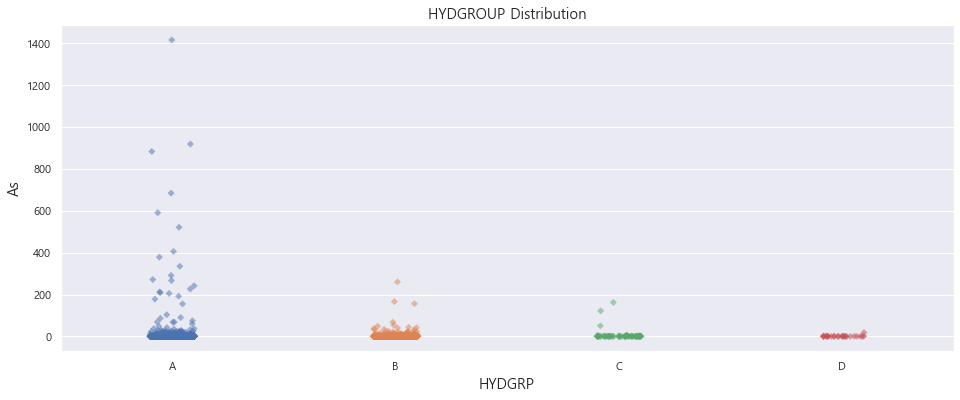

In [278]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('As Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'As', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='Cd'>

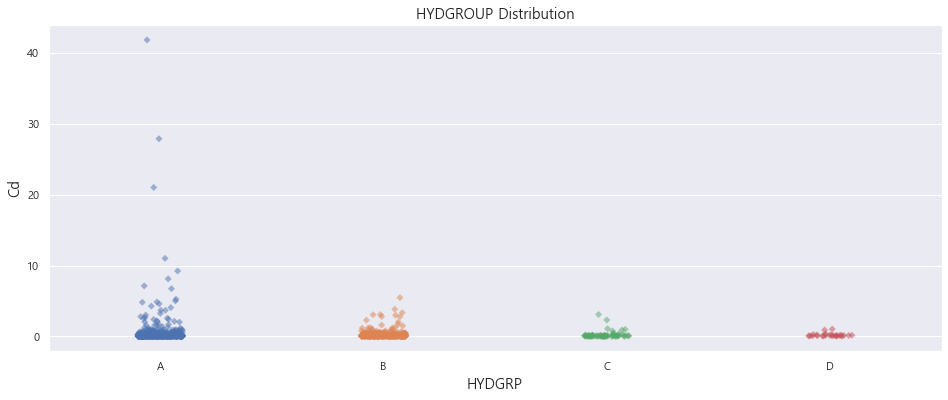

In [279]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('Cd Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'Cd', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='Ni'>

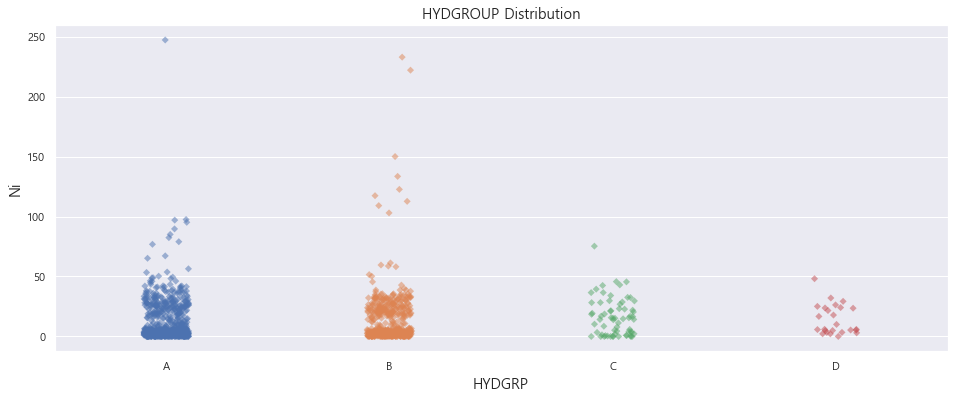

In [280]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('Ni Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'Ni', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

#### Curve Distribution

In [281]:
def visual_curve(data, value):
    fig, ax = plt.subplots(figsize=(16, 6))

    ax.set_title('Curve Distribution', size='large')
    ax.set_xlabel('profile curve', size='large')
    ax.set_ylabel(value+' Concentration', size='large')

    plt.scatter(x = 'profile_curve', y = value, data = data, marker='D', alpha=.5)
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.set_title('Curve Distribution', size='large')
    ax.set_xlabel('planform curve', size='large')
    ax.set_ylabel(value+' Concentration', size='large')

    plt.scatter(x = 'planform_curve', y = value, data = data, marker='D', alpha=.5, c='red')
    plt.show()

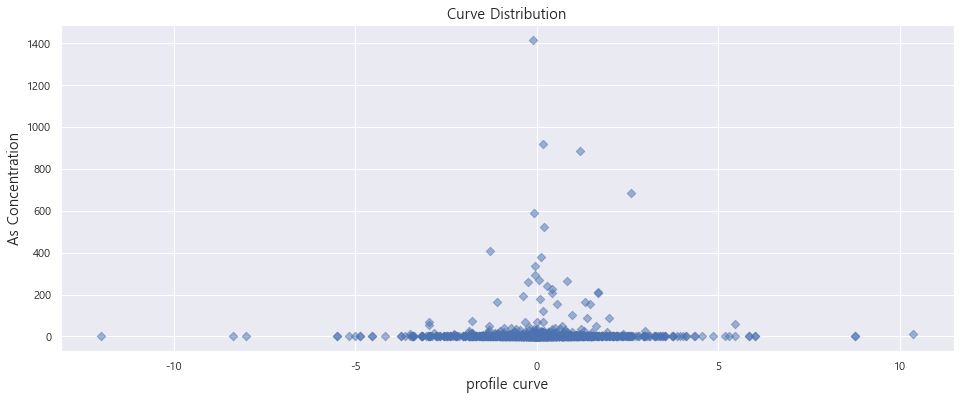

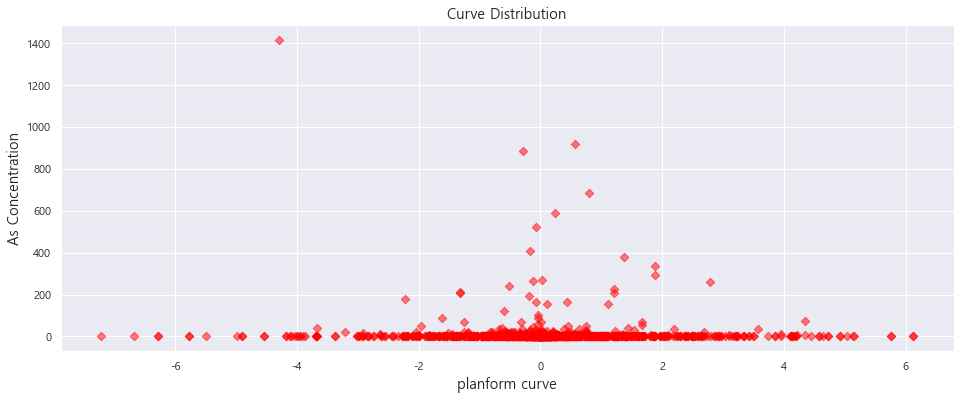

In [282]:
visual_curve(data, 'As')

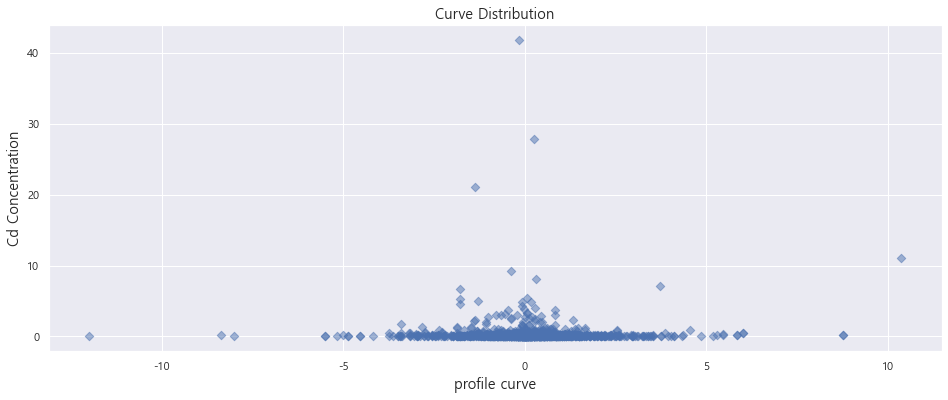

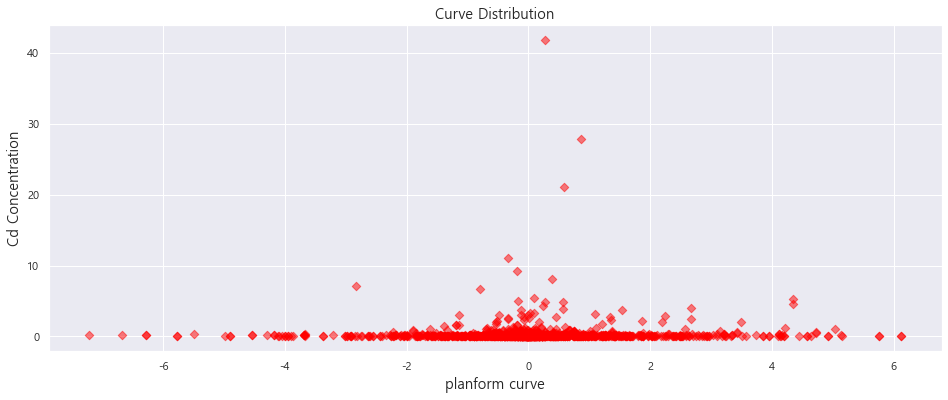

In [283]:
visual_curve(data, 'Cd')

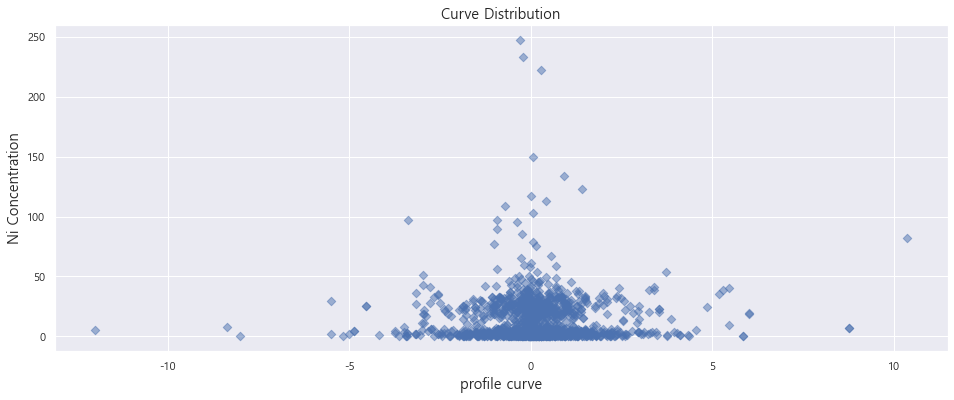

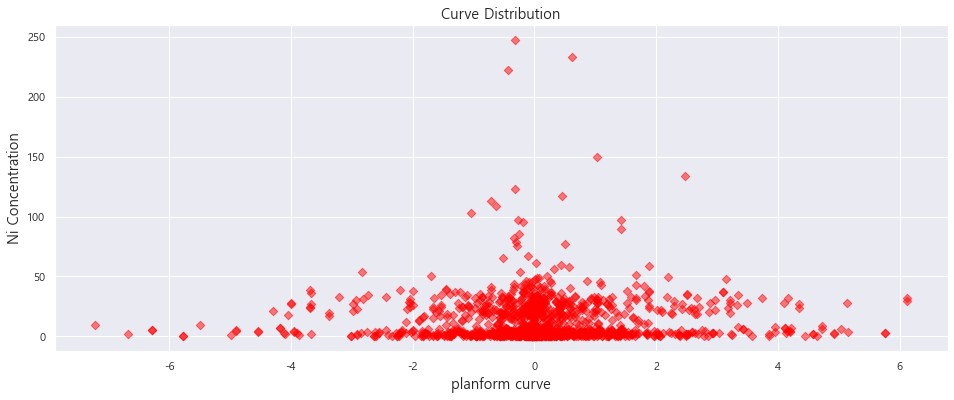

In [284]:
visual_curve(data, 'Ni')

### Processing missing data & Drop unnecessary data

In [285]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

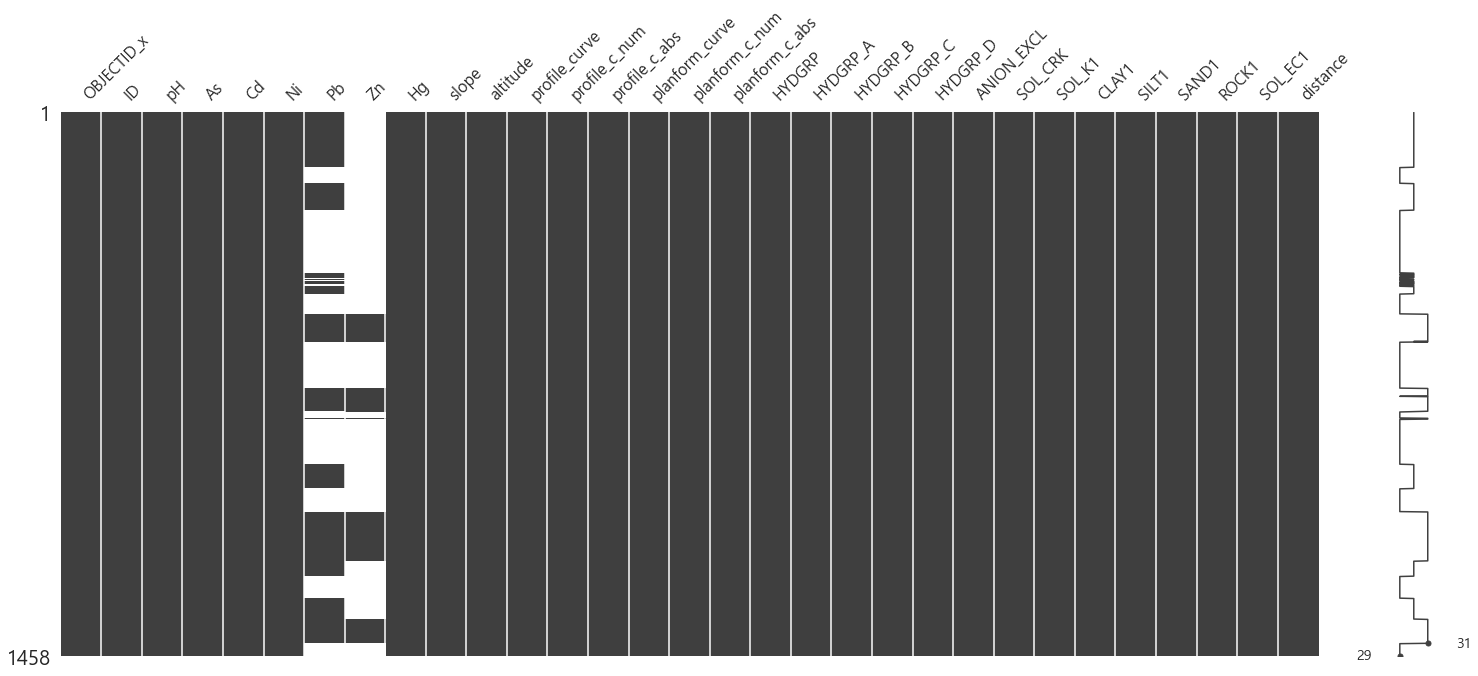

In [286]:
msno.matrix(data)

### YJ mine drop

In [287]:
mine_data = data.loc[263:299,:]

In [288]:
for i in range(263, 300):
    data = data.drop(index = i)

In [289]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [290]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [291]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [292]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [293]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [294]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 114 to 1199
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1006 non-null   float64
 1   As              1006 non-null   float64
 2   slope           1006 non-null   float64
 3   altitude        1006 non-null   float64
 4   profile_c_num   1006 non-null   float64
 5   profile_c_abs   1006 non-null   int64  
 6   planform_c_num  1006 non-null   float64
 7   planform_c_abs  1006 non-null   int64  
 8   HYDGRP_A        1006 non-null   int64  
 9   HYDGRP_B        1006 non-null   int64  
 10  HYDGRP_C        1006 non-null   int64  
 11  HYDGRP_D        1006 non-null   int64  
 12  SOL_K1          1006 non-null   float64
 13  CLAY1           1006 non-null   float64
 14  SILT1           1006 non-null   float64
 15  SAND1           1006 non-null   float64
 16  ROCK1           1006 non-null   float64
 17  distance        1006 non-null  

In [295]:
As_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 188 to 720
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              218 non-null    float64
 1   slope           218 non-null    float64
 2   altitude        218 non-null    float64
 3   profile_c_num   218 non-null    float64
 4   profile_c_abs   218 non-null    int64  
 5   planform_c_num  218 non-null    float64
 6   planform_c_abs  218 non-null    int64  
 7   HYDGRP_A        218 non-null    int64  
 8   HYDGRP_B        218 non-null    int64  
 9   HYDGRP_C        218 non-null    int64  
 10  HYDGRP_D        218 non-null    int64  
 11  SOL_K1          218 non-null    float64
 12  CLAY1           218 non-null    float64
 13  SILT1           218 non-null    float64
 14  SAND1           218 non-null    float64
 15  ROCK1           218 non-null    float64
 16  distance        218 non-null    float64
dtypes: float64(11), int64(6)
memory u

### Check the value skewed

#### As

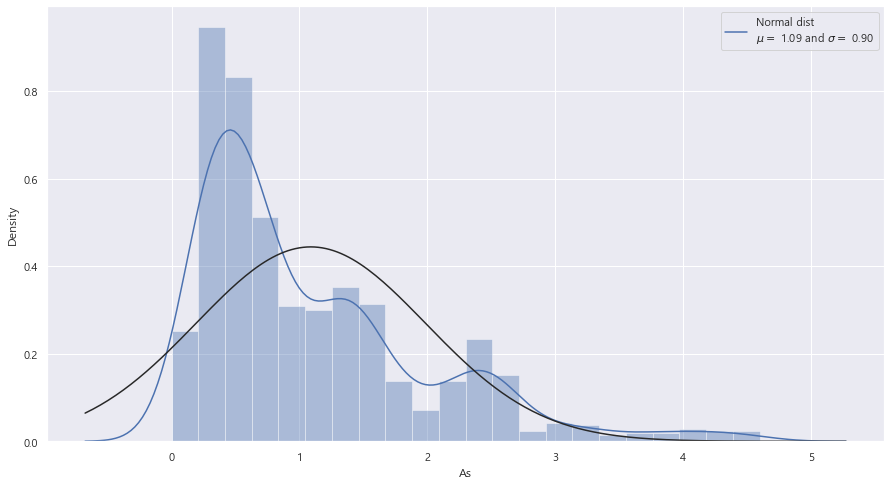

In [296]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

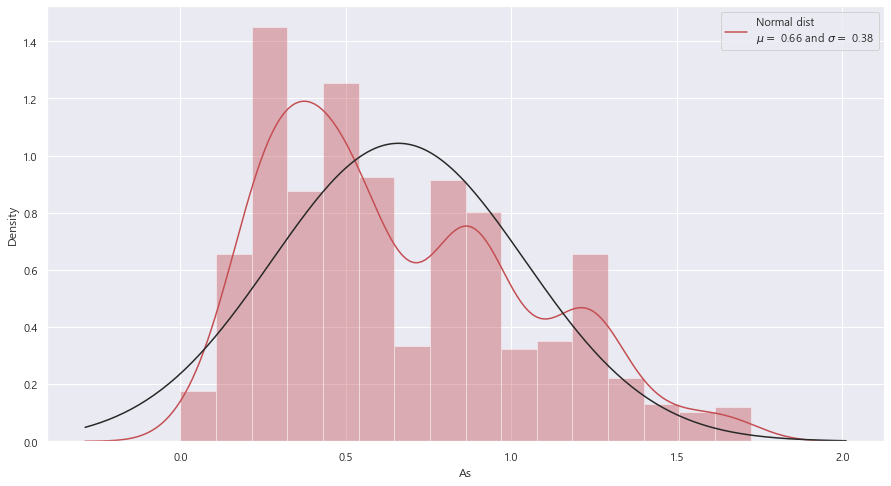

In [297]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

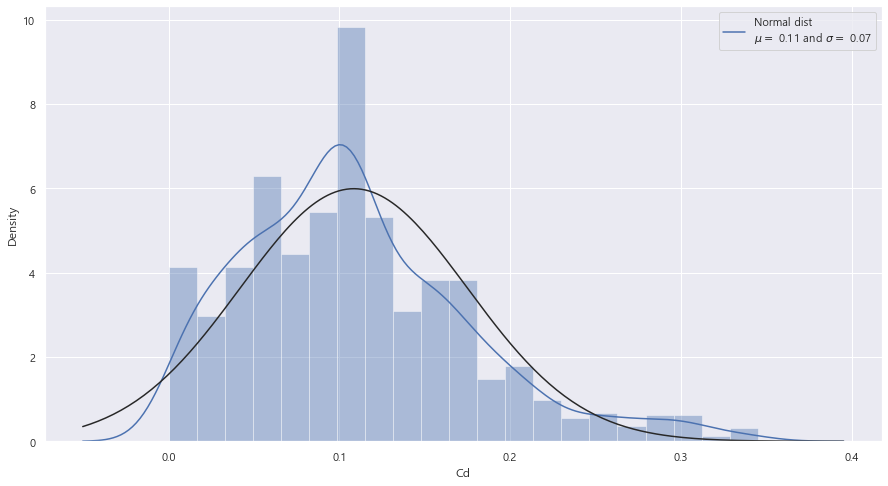

In [298]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

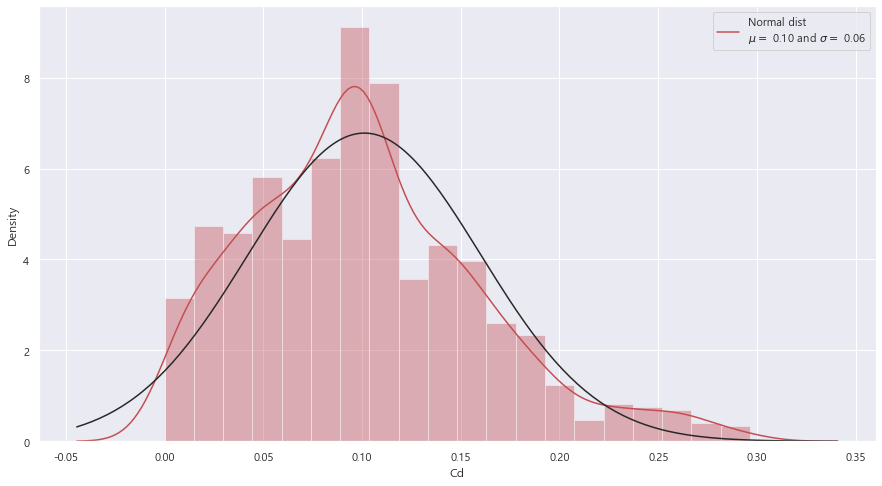

In [299]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

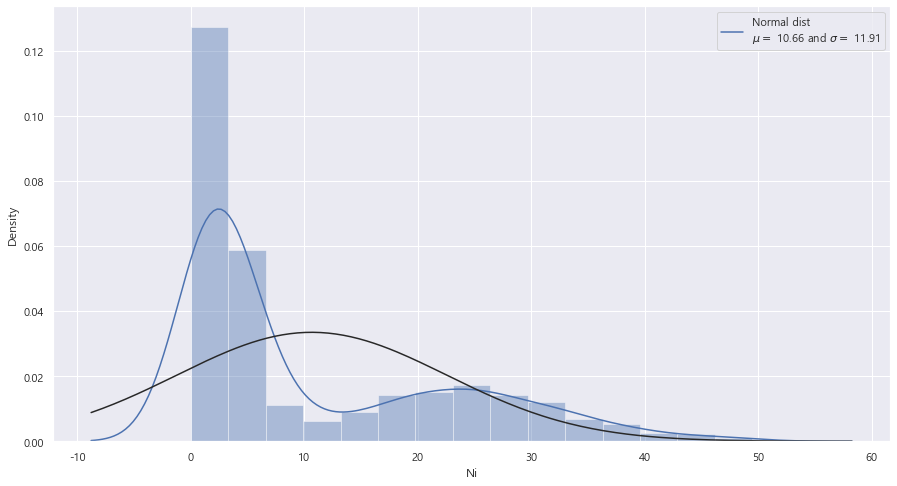

In [300]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

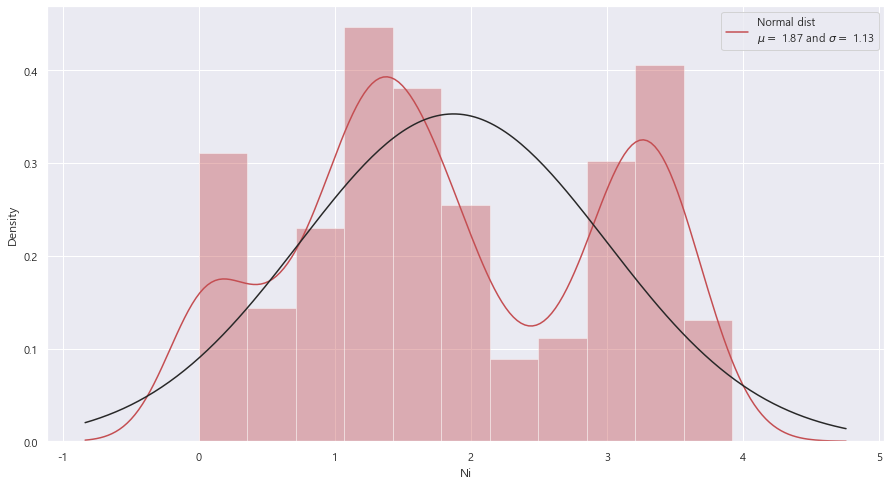

In [301]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [302]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

"""
As_train.altitude = np.log1p(As_train.altitude)
Cd_train.altitude = np.log1p(Cd_train.altitude)
Ni_train.altitude = np.log1p(Ni_train.altitude)

As_train.slope = np.log1p(As_train.slope)
Cd_train.slope = np.log1p(Cd_train.slope)
Ni_train.slope = np.log1p(Ni_train.slope)
"""

'\nAs_train.altitude = np.log1p(As_train.altitude)\nCd_train.altitude = np.log1p(Cd_train.altitude)\nNi_train.altitude = np.log1p(Ni_train.altitude)\n\nAs_train.slope = np.log1p(As_train.slope)\nCd_train.slope = np.log1p(Cd_train.slope)\nNi_train.slope = np.log1p(Ni_train.slope)\n'

In [303]:
As_test_index = As_test.index
Cd_test_index = Cd_test.index
Ni_test_index = Ni_test.index

#### Scaling

In [304]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [305]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler.fit(As_X)
As_X = pd.DataFrame(scaler.transform(As_X), columns=As_X.columns)
As_test = pd.DataFrame(scaler.transform(As_test), columns=As_test.columns)

scaler.fit(Cd_X)
Cd_X = pd.DataFrame(scaler.transform(Cd_X), columns=Cd_X.columns)
Cd_test = pd.DataFrame(scaler.transform(Cd_test), columns=Cd_test.columns)

scaler.fit(Ni_X)
Ni_X = pd.DataFrame(scaler.transform(Ni_X), columns=Ni_X.columns)
Ni_test = pd.DataFrame(scaler.transform(Ni_test), columns=Ni_test.columns)

#### 10-Fold Crossvalidation

In [306]:
kf = KFold(n_splits = 20, random_state = 605, shuffle = True)

In [ ]:
def cal_test_r2(pred, data, idx):
    

#### 1) NGBRegressor

In [307]:
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

def ngb_model(test, X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.001)
    
    ngb_pred = np.zeros((test.shape[0]))
    test_ngb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        ngb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 20
        ngb_pred += sub_pred

    print(f'{ngb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    return ngb_pred

In [308]:
As_ngb_pred = ngb_model(As_test, As_X, As_y)

[iter 0] loss=0.4631 val_loss=0.0000 scale=1.0000 norm=0.5735
[iter 100] loss=0.4434 val_loss=0.0000 scale=1.0000 norm=0.5585
[iter 200] loss=0.4246 val_loss=0.0000 scale=1.0000 norm=0.5461
[iter 300] loss=0.4093 val_loss=0.0000 scale=1.0000 norm=0.5374
[iter 400] loss=0.3940 val_loss=0.0000 scale=1.0000 norm=0.5294
[iter 500] loss=0.3778 val_loss=0.0000 scale=2.0000 norm=1.0443
[iter 600] loss=0.3638 val_loss=0.0000 scale=1.0000 norm=0.5170
[iter 700] loss=0.3526 val_loss=0.0000 scale=1.0000 norm=0.5134
[iter 800] loss=0.3422 val_loss=0.0000 scale=2.0000 norm=1.0210
[iter 900] loss=0.3313 val_loss=0.0000 scale=2.0000 norm=1.0160
[iter 0] loss=0.3186 val_loss=0.0000 scale=1.0000 norm=0.5070
[iter 100] loss=0.3082 val_loss=0.0000 scale=1.0000 norm=0.5046
[iter 200] loss=0.2994 val_loss=0.0000 scale=1.0000 norm=0.5025
[iter 300] loss=0.2899 val_loss=0.0000 scale=1.0000 norm=0.5009
[iter 400] loss=0.2800 val_loss=0.0000 scale=2.0000 norm=0.9979
[iter 500] loss=0.2717 val_loss=0.0000 scale

In [355]:
Cd_ngb_pred = ngb_model(Cd_test, Cd_X, Cd_y)

[iter 0] loss=-1.4165 val_loss=0.0000 scale=2.0000 norm=1.0059
[iter 100] loss=-1.4538 val_loss=0.0000 scale=1.0000 norm=0.4767
[iter 200] loss=-1.4779 val_loss=0.0000 scale=2.0000 norm=0.9265
[iter 300] loss=-1.4982 val_loss=0.0000 scale=2.0000 norm=0.9087
[iter 400] loss=-1.5176 val_loss=0.0000 scale=2.0000 norm=0.8953
[iter 500] loss=-1.5342 val_loss=0.0000 scale=2.0000 norm=0.8860
[iter 600] loss=-1.5480 val_loss=0.0000 scale=1.0000 norm=0.4399
[iter 700] loss=-1.5617 val_loss=0.0000 scale=1.0000 norm=0.4363
[iter 800] loss=-1.5744 val_loss=0.0000 scale=2.0000 norm=0.8684
[iter 900] loss=-1.5865 val_loss=0.0000 scale=1.0000 norm=0.4325
[iter 0] loss=-1.5847 val_loss=0.0000 scale=1.0000 norm=0.4342
[iter 100] loss=-1.5941 val_loss=0.0000 scale=1.0000 norm=0.4318
[iter 200] loss=-1.6041 val_loss=0.0000 scale=2.0000 norm=0.8582
[iter 300] loss=-1.6146 val_loss=0.0000 scale=1.0000 norm=0.4269
[iter 400] loss=-1.6236 val_loss=0.0000 scale=1.0000 norm=0.4268
[iter 500] loss=-1.6320 val_l

In [310]:
Ni_ngb_pred = ngb_model(Ni_test, Ni_X, Ni_y)

[iter 0] loss=1.5375 val_loss=0.0000 scale=1.0000 norm=1.0991
[iter 100] loss=1.5087 val_loss=0.0000 scale=1.0000 norm=1.0726
[iter 200] loss=1.4796 val_loss=0.0000 scale=1.0000 norm=1.0460
[iter 300] loss=1.4555 val_loss=0.0000 scale=1.0000 norm=1.0242
[iter 400] loss=1.4337 val_loss=0.0000 scale=1.0000 norm=1.0051
[iter 500] loss=1.4040 val_loss=0.0000 scale=1.0000 norm=0.9786
[iter 600] loss=1.3756 val_loss=0.0000 scale=1.0000 norm=0.9547
[iter 700] loss=1.3533 val_loss=0.0000 scale=2.0000 norm=1.8753
[iter 800] loss=1.3257 val_loss=0.0000 scale=2.0000 norm=1.8356
[iter 900] loss=1.3068 val_loss=0.0000 scale=1.0000 norm=0.9054
[iter 0] loss=1.2897 val_loss=0.0000 scale=1.0000 norm=0.8958
[iter 100] loss=1.2680 val_loss=0.0000 scale=2.0000 norm=1.7659
[iter 200] loss=1.2496 val_loss=0.0000 scale=1.0000 norm=0.8725
[iter 300] loss=1.2327 val_loss=0.0000 scale=1.0000 norm=0.8631
[iter 400] loss=1.2164 val_loss=0.0000 scale=1.0000 norm=0.8548
[iter 500] loss=1.2003 val_loss=0.0000 scale

#### 2) RandomForestRegressor

In [311]:
def rf_model(test, X, y):
    rf = RandomForestRegressor(random_state = 605, n_estimators = 1000)
    
    rf_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        rf.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(test)]) / 20
        rf_pred += sub_pred

    print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')
    return rf_pred

In [312]:
As_rf_pred = rf_model(As_test, As_X, As_y)

RandomForestRegressor의 10fold 평균 RMSE는 0.8478871099959683


In [313]:
Cd_rf_pred = rf_model(Cd_test, Cd_X, Cd_y)

RandomForestRegressor의 10fold 평균 RMSE는 0.06136718528692814


In [314]:
Ni_rf_pred = rf_model(Ni_test, Ni_X, Ni_y)

RandomForestRegressor의 10fold 평균 RMSE는 6.937082889391542


#### 3) ExtraTreesRegressor

In [315]:
def etc_model(test, X, y):
    etc = ExtraTreesRegressor(random_state = 605, n_estimators = 1000)
    
    etc_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        etc.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(test)]) / 20
        etc_pred += sub_pred

    print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')
    return etc_pred

In [316]:
As_etc_pred = etc_model(As_test, As_X, As_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 0.8824839187155564


In [317]:
Cd_etc_pred = etc_model(Cd_test, Cd_X, Cd_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 0.06377209825042267


In [318]:
Ni_etc_pred = etc_model(Ni_test, Ni_X, Ni_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 6.699426087784748


#### 4) GradientBoostingRegressor

In [319]:
def gb_model(test, X, y):
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 1000, learning_rate = 0.001, max_depth = 5)
    
    gb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(test)]) / 20
        gb_pred += sub_pred

    print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')
    return gb_pred

In [ ]:
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

def ngb_model(test, mine, X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.1, verbose=False)
    
    ngb_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        ngb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
        
        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 20
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in ngb.predict(mine)]) / 20
        
        ngb_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'{ngb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    return ngb_pred, mine_pred

def ngb_train_model(X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.1, verbose=False)

    ngb.fit(X, y)
    train_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(X)])
    #r2 = cal_train_r2(train_pred, np.expm1(y))
    r2 = r2_score(np.expm1(y), train_pred)

    print(f'R2 score는 {r2}')

In [320]:
As_gb_pred = gb_model(As_test, As_X, As_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 0.8545072236436544


In [321]:
Cd_gb_pred = gb_model(Cd_test, Cd_X, Cd_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 0.06259799600623803


In [322]:
Ni_gb_pred = gb_model(Ni_test, Ni_X, Ni_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 10.443704666835005


#### 5) CatBoostRegressor

In [323]:
def cb_model(test, X, y):
    cb = CatBoostRegressor(random_state = 605, silent = True, depth = 5, learning_rate = 0.001)
    
    cb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        cb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(test)]) / 20
        cb_pred += sub_pred

    print(f'{cb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')
    return cb_pred

In [324]:
As_cb_pred = cb_model(As_test, As_X, As_y)

CatBoostRegressor의 10fold 평균 RMSE는 0.8732712231347483


In [325]:
Cd_cb_pred = cb_model(Cd_test, Cd_X, Cd_y)

CatBoostRegressor의 10fold 평균 RMSE는 0.06447089774337042


In [326]:
Ni_cb_pred = cb_model(Ni_test, Ni_X, Ni_y)

CatBoostRegressor의 10fold 평균 RMSE는 11.636265783438791


#### 6) LGBMRegressor

In [327]:
def lgbm_model(test, X, y):
    lgbm = LGBMRegressor(random_state = 605, max_depth = 4, n_estimators = 1000, num_leaves = 16, learning_rate = 0.001, num_iterations = 1000)
    
    lgbm_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        lgbm.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(test)]) / 20
        lgbm_pred += sub_pred

    print(f'{lgbm.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')
    return lgbm_pred

In [328]:
As_lgbm_pred = lgbm_model(As_test, As_X, As_y)

LGBMRegressor의 10fold 평균 RMSE는 0.8677084610444668


In [329]:
Cd_lgbm_pred = lgbm_model(Cd_test, Cd_X, Cd_y)

LGBMRegressor의 10fold 평균 RMSE는 0.06262917260217246


In [330]:
Ni_lgbm_pred = lgbm_model(Ni_test, Ni_X, Ni_y)

LGBMRegressor의 10fold 평균 RMSE는 11.032032683365179


#### 7) XGBRegressor

In [331]:
def xgb_model(test, X, y):
    xgb = XGBRegressor(random_state = 605, max_depth = 30, learning_rate = 0.1)
    
    xgb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        xgb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(test)]) / 20
        xgb_pred += sub_pred

    print(f'{xgb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')
    return xgb_pred

In [332]:
As_xgb_pred = xgb_model(As_test, As_X, As_y)

XGBRegressor의 10fold 평균 RMSE는 0.9112810118246628


In [333]:
Cd_xgb_pred = xgb_model(Cd_test, Cd_X, Cd_y)

XGBRegressor의 10fold 평균 RMSE는 0.06522684631564095


In [334]:
Ni_xgb_pred = xgb_model(Ni_test, Ni_X, Ni_y)

XGBRegressor의 10fold 평균 RMSE는 6.800890467227963


###  Blending Models

In [335]:
#As
ngb_As_test = pd.DataFrame()
rf_As_test = pd.DataFrame()
etc_As_test = pd.DataFrame()
gb_As_test = pd.DataFrame()
cb_As_test = pd.DataFrame()
lgbm_As_test = pd.DataFrame()
xgb_As_test = pd.DataFrame()

#Cd
ngb_Cd_test = pd.DataFrame()
rf_Cd_test = pd.DataFrame()
etc_Cd_test = pd.DataFrame()
gb_Cd_test = pd.DataFrame()
cb_Cd_test = pd.DataFrame()
lgbm_Cd_test = pd.DataFrame()
xgb_Cd_test = pd.DataFrame()

#Ni
ngb_Ni_test = pd.DataFrame()
rf_Ni_test = pd.DataFrame()
etc_Ni_test = pd.DataFrame()
gb_Ni_test = pd.DataFrame()
cb_Ni_test = pd.DataFrame()
lgbm_Ni_test = pd.DataFrame()
xgb_Ni_test = pd.DataFrame()


In [336]:
#test['As_value'] = (gb_pred + rf_pred + etc_pred + lgbm_pred + cb_pred + ngb_pred + xgb_pred) / 7
ngb_As_test['As_value'] = As_ngb_pred
ngb_Cd_test['Cd_value'] = Cd_ngb_pred
ngb_Ni_test['Ni_value'] = Ni_ngb_pred

rf_As_test['As_value'] = As_rf_pred
rf_Cd_test['Cd_value'] = Cd_rf_pred
rf_Ni_test['Ni_value'] = Ni_rf_pred

etc_As_test['As_value'] = As_etc_pred
etc_Cd_test['Cd_value'] = Cd_etc_pred
etc_Ni_test['Ni_value'] = Ni_etc_pred

gb_As_test['As_value'] = As_gb_pred
gb_Cd_test['Cd_value'] = Cd_gb_pred
gb_Ni_test['Ni_value'] = Ni_gb_pred

cb_As_test['As_value'] = As_cb_pred
cb_Cd_test['Cd_value'] = Cd_cb_pred
cb_Ni_test['Ni_value'] = Ni_cb_pred

lgbm_As_test['As_value'] = As_lgbm_pred
lgbm_Cd_test['Cd_value'] = Cd_lgbm_pred
lgbm_Ni_test['Ni_value'] = Ni_lgbm_pred

xgb_As_test['As_value'] = As_xgb_pred
xgb_Cd_test['Cd_value'] = Cd_xgb_pred
xgb_Ni_test['Ni_value'] = Ni_xgb_pred

In [337]:
print(ngb_As_test.loc[:,'As_value'])

0      0.825221
1      1.260680
2      1.306413
3      0.941750
4      0.755961
         ...   
213    1.219405
214    1.416254
215    0.818288
216    1.000608
217    0.698839
Name: As_value, Length: 218, dtype: float64


In [338]:
def data_scailing(test, value):
    q1 = test[value].quantile(0.004)
    q2 = test[value].quantile(0.99)
    
    test[value] = test[value].apply(lambda x: x if x > q1 else x * 0.9)
    test[value] = test[value].apply(lambda x: x if x < q2 else x * 1.1)
    
    return test

In [339]:
# As
ngb_As_test = data_scailing(ngb_As_test, 'As_value')
rf_As_test = data_scailing(rf_As_test, 'As_value')
etc_As_test = data_scailing(etc_As_test, 'As_value')
gb_As_test = data_scailing(gb_As_test, 'As_value')
cb_As_test = data_scailing(cb_As_test, 'As_value')
lgbm_As_test = data_scailing(lgbm_As_test, 'As_value')
xgb_As_test = data_scailing(xgb_As_test, 'As_value')

# Cd
ngb_Cd_test = data_scailing(ngb_Cd_test, 'Cd_value')
rf_Cd_test = data_scailing(rf_Cd_test, 'Cd_value')
etc_Cd_test = data_scailing(etc_Cd_test, 'Cd_value')
gb_Cd_test = data_scailing(gb_Cd_test, 'Cd_value')
cb_Cd_test = data_scailing(cb_Cd_test, 'Cd_value')
lgbm_Cd_test = data_scailing(lgbm_Cd_test, 'Cd_value')
xgb_Cd_test = data_scailing(xgb_Cd_test, 'Cd_value')

# Ni
ngb_Ni_test = data_scailing(ngb_Ni_test, 'Ni_value')
rf_Ni_test = data_scailing(rf_Ni_test, 'Ni_value')
etc_Ni_test = data_scailing(etc_Ni_test, 'Ni_value')
gb_Ni_test = data_scailing(gb_Ni_test, 'Ni_value')
cb_Ni_test = data_scailing(cb_Ni_test, 'Ni_value')
lgbm_Ni_test = data_scailing(lgbm_Ni_test, 'Ni_value')
xgb_Ni_test = data_scailing(xgb_Ni_test, 'Ni_value')

In [340]:
ngb_As_test['index'] = As_test_index
rf_As_test['index'] = As_test_index
etc_As_test['index'] = As_test_index
gb_As_test['index'] = As_test_index
cb_As_test['index'] = As_test_index
lgbm_As_test['index'] = As_test_index
xgb_As_test['index'] = As_test_index

ngb_Cd_test['index'] = Cd_test_index
rf_Cd_test['index'] = Cd_test_index
etc_Cd_test['index'] = Cd_test_index
gb_Cd_test['index'] = Cd_test_index
cb_Cd_test['index'] = Cd_test_index
lgbm_Cd_test['index'] = Cd_test_index
xgb_Cd_test['index'] = Cd_test_index

ngb_Ni_test['index'] = Ni_test_index
rf_Ni_test['index'] = Ni_test_index
etc_Ni_test['index'] = Ni_test_index
gb_Ni_test['index'] = Ni_test_index
cb_Ni_test['index'] = Ni_test_index
lgbm_Ni_test['index'] = Ni_test_index
xgb_Ni_test['index'] = Ni_test_index

In [341]:
for index in ngb_As_test['index']:
    ngb_As_test.loc[ngb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    rf_As_test.loc[rf_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    etc_As_test.loc[etc_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    gb_As_test.loc[gb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    cb_As_test.loc[cb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    lgbm_As_test.loc[lgbm_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    xgb_As_test.loc[xgb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']

for index in ngb_Cd_test['index']:
    ngb_Cd_test.loc[ngb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    rf_Cd_test.loc[rf_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    etc_Cd_test.loc[etc_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    gb_Cd_test.loc[gb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    cb_Cd_test.loc[cb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    lgbm_Cd_test.loc[lgbm_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    xgb_Cd_test.loc[xgb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    
for index in ngb_Ni_test['index']:
    ngb_Ni_test.loc[ngb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    rf_Ni_test.loc[rf_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    etc_Ni_test.loc[etc_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    gb_Ni_test.loc[gb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    cb_Ni_test.loc[cb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    lgbm_Ni_test.loc[lgbm_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    xgb_Ni_test.loc[xgb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [342]:
print(ngb_As_test.loc[:,('As_real_value', 'As_value')])

     As_real_value  As_value
0             1.35  0.825221
1             2.35  1.260680
2             1.25  1.306413
3             0.44  0.941750
4             2.47  0.755961
..             ...       ...
213           0.36  1.219405
214           2.74  1.416254
215           1.67  0.818288
216           1.36  1.000608
217           0.27  0.698839

[218 rows x 2 columns]


In [343]:
print(rf_As_test.loc[:,('As_real_value', 'As_value')])

     As_real_value  As_value
0             1.35  1.131995
1             2.35  1.377710
2             1.25  1.001601
3             0.44  0.910498
4             2.47  0.533698
..             ...       ...
213           0.36  0.986697
214           2.74  1.340528
215           1.67  1.039241
216           1.36  1.095703
217           0.27  0.592834

[218 rows x 2 columns]


In [344]:
print(ngb_Ni_test.loc[:,('Ni_real_value', 'Ni_value')])

     Ni_real_value   Ni_value
0             4.61   8.849935
1             0.69   4.580264
2             3.41   6.034133
3             5.38   4.357803
4             8.94   2.060928
..             ...        ...
213          24.43  16.405905
214           3.55   1.931518
215          32.87  12.292264
216           3.57   5.760822
217           2.41   3.529053

[218 rows x 2 columns]


#### R2 scoring

In [345]:
def SST(data, pred):
    sst = 0
    
    for i in range(0, len(data)):
        sst += (data[i] - np.mean(data))**2
    
    return sst

def SSE(data, pred):
    sse = 0
    
    for i in range(0, len(data)):
        sse += (pred[i] - np.mean(data))**2
        
    return sse


def SSR(data, pred):
    ssr = 0
    
    for i in range(0, len(data)):
        ssr += (data[i] - pred[i])**2
    
    return ssr

def cal_r2_score(list, value, pred_value):
    r2_list = []
    model_list = ['NGBR','RandomForest','ExtraTrees','GradientBoost','CatBoost','LightGBM','XGBR']
    index = 0
    
    for item in list:
        #r2_list.append(1 - (((len(data)-1)/(len(data)-18))*(SSR(item[value], item[pred_value])/SST(item[value], item[pred_value]))))
        r2_list.append(SSE(item[value], item[pred_value])/SST(item[value], item[pred_value]))
    
    for item in r2_list:
        print(model_list[index]+' '+pred_value+' R2 score : '+str(item))
        index += 1

In [346]:
r2_As_list = [ngb_As_test, rf_As_test, etc_As_test, gb_As_test, cb_As_test, lgbm_As_test, xgb_As_test]
r2_Cd_list = [ngb_Cd_test, rf_Cd_test, etc_Cd_test, gb_Cd_test, cb_Cd_test, lgbm_Cd_test, xgb_Cd_test]
r2_Ni_list = [ngb_Ni_test, rf_Ni_test, etc_Ni_test, gb_Ni_test, cb_Ni_test, lgbm_Ni_test, xgb_Ni_test]

In [347]:
cal_r2_score(r2_As_list, 'As_real_value', 'As_value')

NGBR As_value R2 score : 0.19809679630191593
RandomForest As_value R2 score : 0.2530746891132861
ExtraTrees As_value R2 score : 0.49231518831063414
GradientBoost As_value R2 score : 0.07549079621013473
CatBoost As_value R2 score : 0.040506636815039604
LightGBM As_value R2 score : 0.061314329493908366
XGBR As_value R2 score : 0.47362499775931216


In [348]:
cal_r2_score(r2_Cd_list, 'Cd_real_value', 'Cd_value')

NGBR Cd_value R2 score : 0.14398691063026992
RandomForest Cd_value R2 score : 0.2442713305295927
ExtraTrees Cd_value R2 score : 0.4304261209289054
GradientBoost Cd_value R2 score : 0.05272902893856557
CatBoost Cd_value R2 score : 0.011908442038357519
LightGBM Cd_value R2 score : 0.042526457128665755
XGBR Cd_value R2 score : 0.39127373754886074


In [349]:
cal_r2_score(r2_Ni_list, 'Ni_real_value', 'Ni_value')

NGBR Ni_value R2 score : 0.393583761447287
RandomForest Ni_value R2 score : 0.46403214529472164
ExtraTrees Ni_value R2 score : 0.5525433411655467
GradientBoost Ni_value R2 score : 0.20126198016766927
CatBoost Ni_value R2 score : 0.15808529668205545
LightGBM Ni_value R2 score : 0.17932857191846355
XGBR Ni_value R2 score : 0.6169272627446711


### Visualization

In [350]:
def visualization(test_list, value, real_value):
    color_list = ['red','orange','yellow','green','blue','gray','purple']
    fig, axs = plt.subplots(figsize=(20, 32), nrows=7, ncols=1)
    
    for i in range(0, len(test_list)):
        x1 = test_list[i].loc[:,value]
        x2 = test_list[i].loc[:,real_value]

        plt.scatter(x1, x2)
        plt.xlabel(value)
        plt.ylabel(real_value)
        plt.show
        #sns.regplot(x1, x2, color = color_list[ind])

In [351]:
vis_As_list = [ngb_As_test, rf_As_test, etc_As_test, gb_As_test, cb_As_test, lgbm_As_test, xgb_As_test]
vis_Cd_list = [ngb_Cd_test, rf_Cd_test, etc_Cd_test, gb_Cd_test, cb_Cd_test, lgbm_Cd_test, xgb_Cd_test]
vis_Ni_list = [ngb_Ni_test, rf_Ni_test, etc_Ni_test, gb_Ni_test, cb_Ni_test, lgbm_Ni_test, xgb_Ni_test]

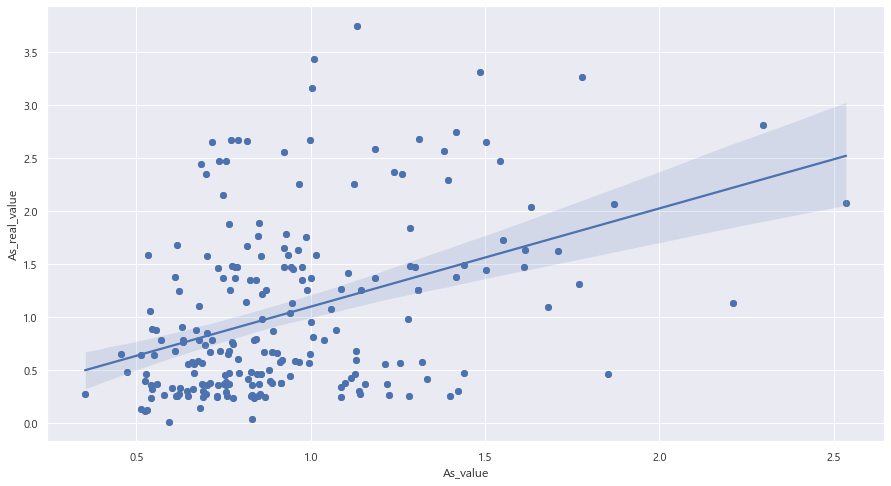

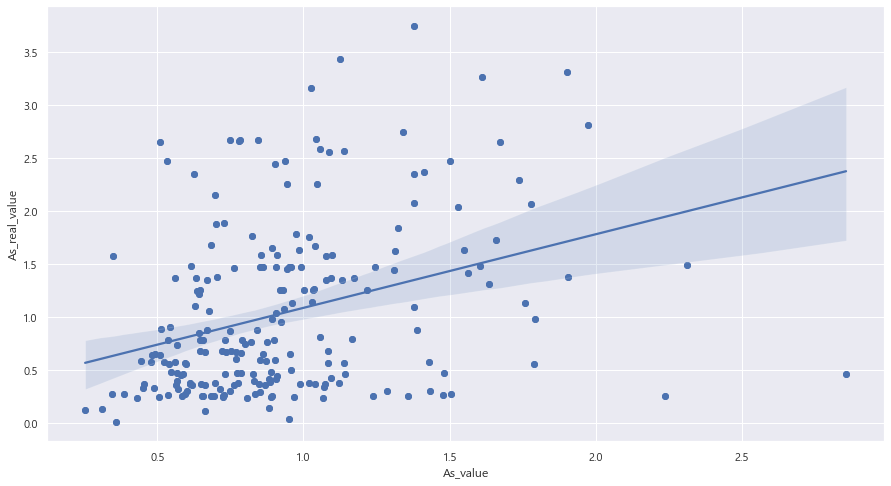

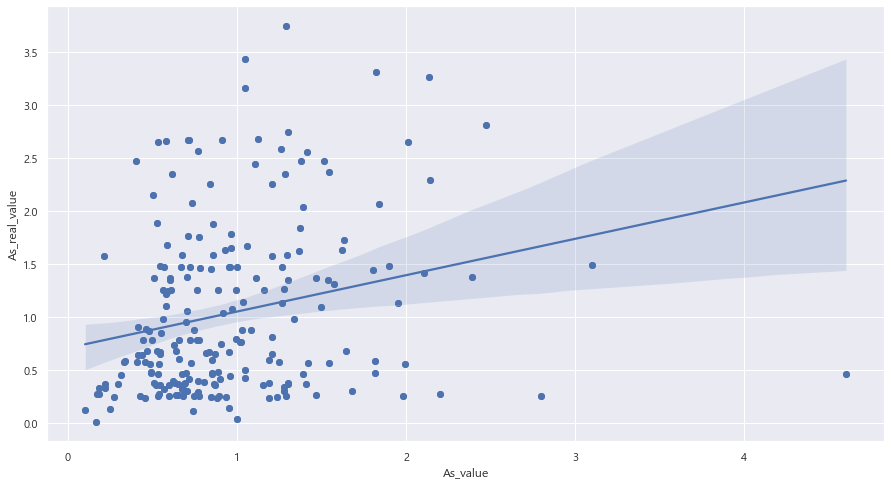

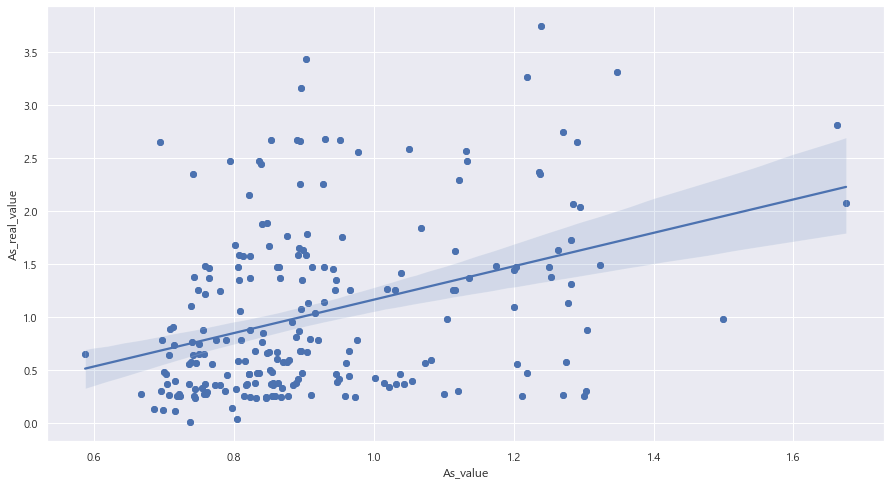

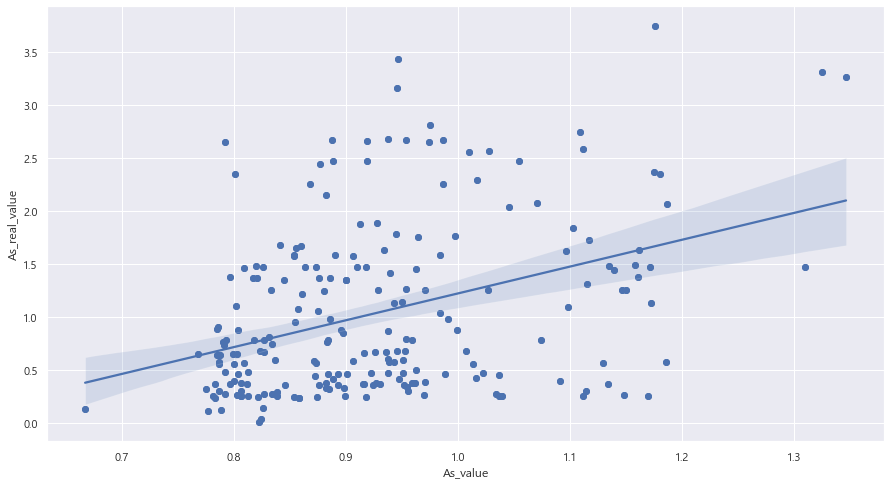

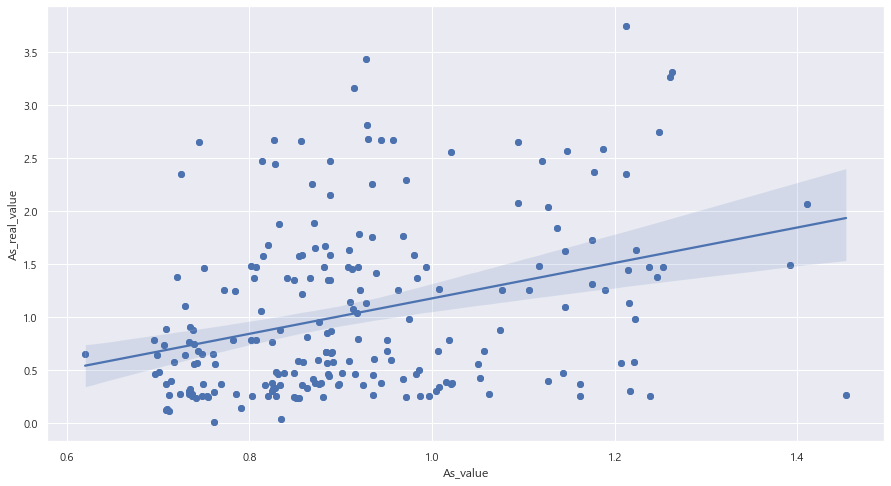

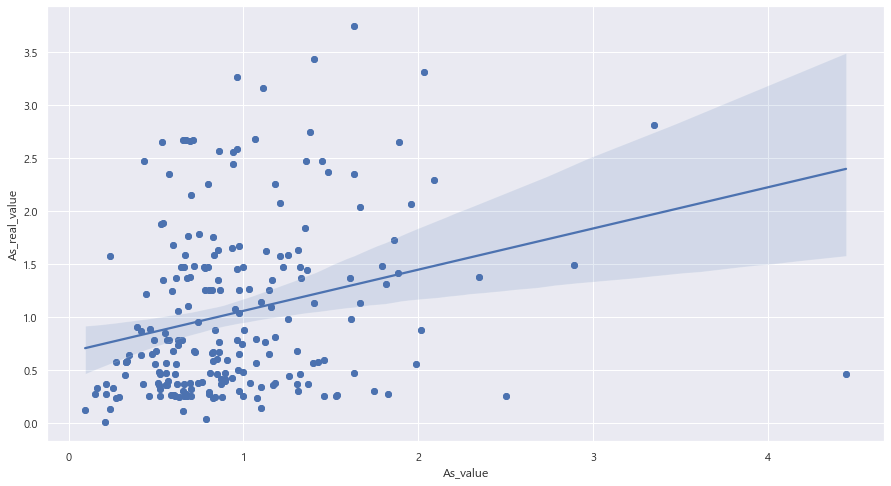

In [352]:
plt.scatter(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
sns.regplot(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
plt.show()

plt.scatter(rf_As_test['As_value'], rf_As_test['As_real_value'])
sns.regplot(rf_As_test['As_value'], rf_As_test['As_real_value'])
plt.show()

plt.scatter(etc_As_test['As_value'], etc_As_test['As_real_value'])
sns.regplot(etc_As_test['As_value'], etc_As_test['As_real_value'])
plt.show()

plt.scatter(gb_As_test['As_value'], gb_As_test['As_real_value'])
sns.regplot(gb_As_test['As_value'], gb_As_test['As_real_value'])
plt.show()

plt.scatter(cb_As_test['As_value'], cb_As_test['As_real_value'])
sns.regplot(cb_As_test['As_value'], cb_As_test['As_real_value'])
plt.show()

plt.scatter(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
sns.regplot(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
plt.show()

plt.scatter(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
sns.regplot(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
plt.show()

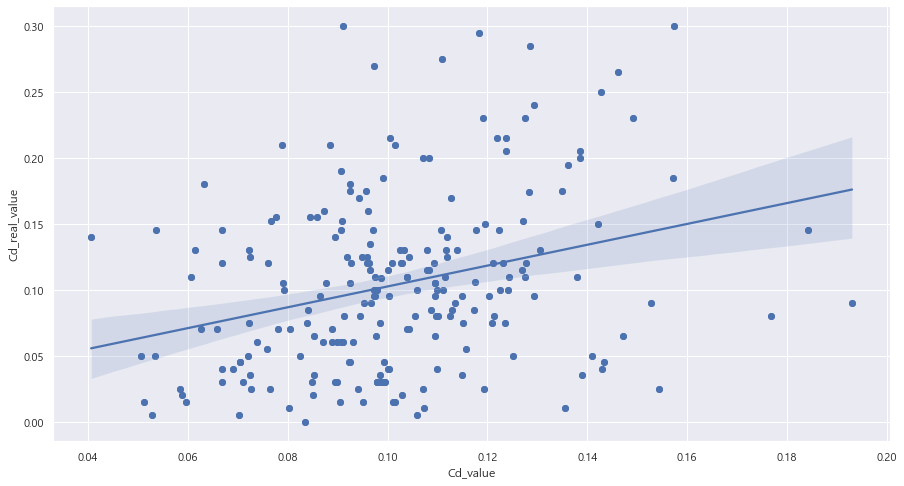

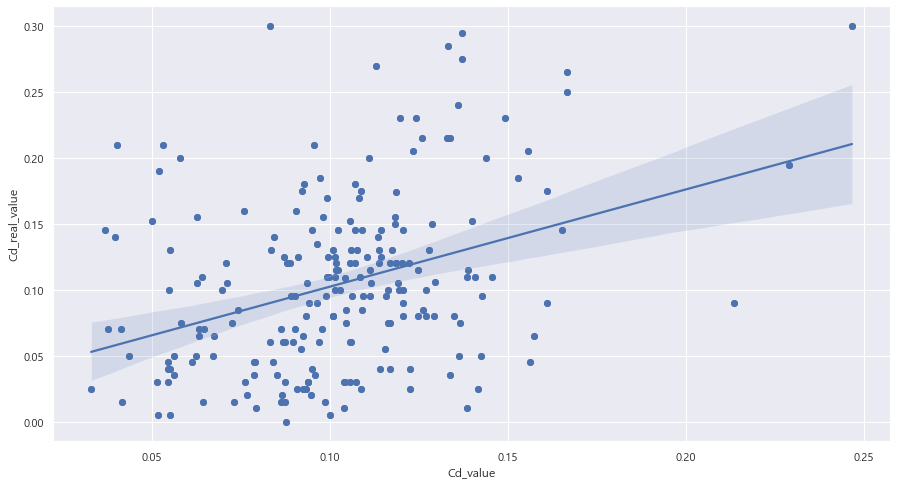

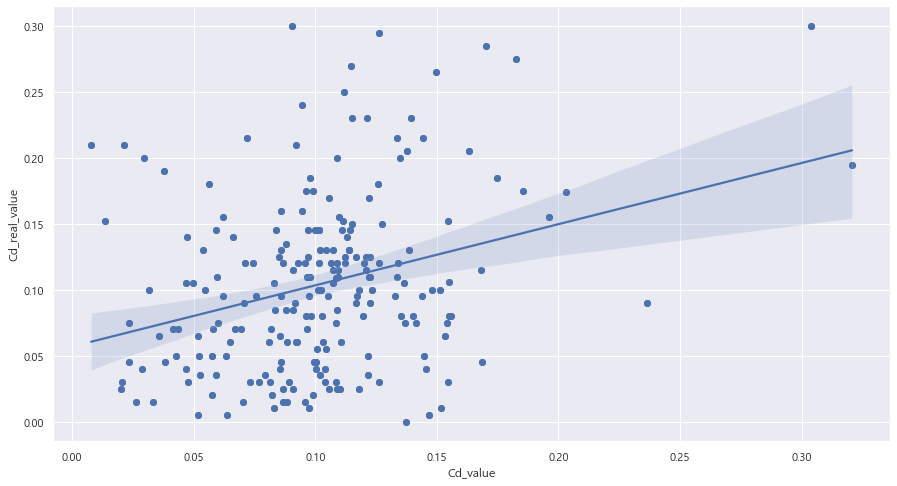

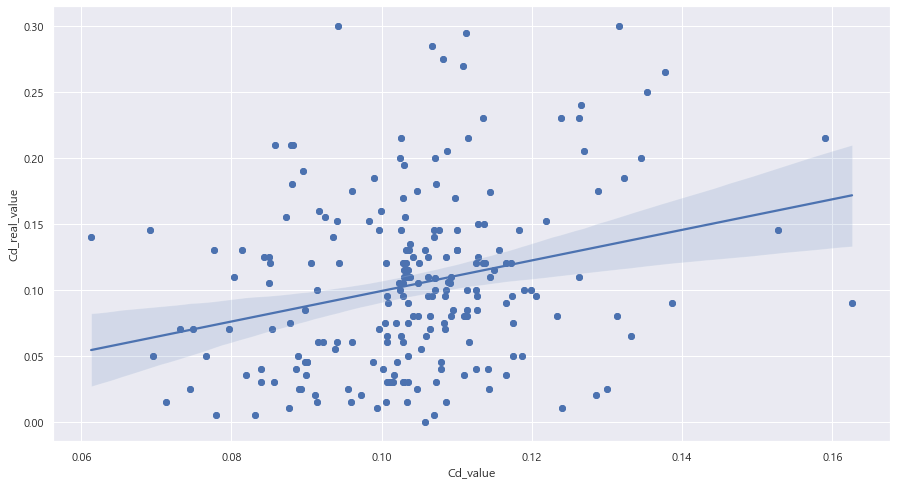

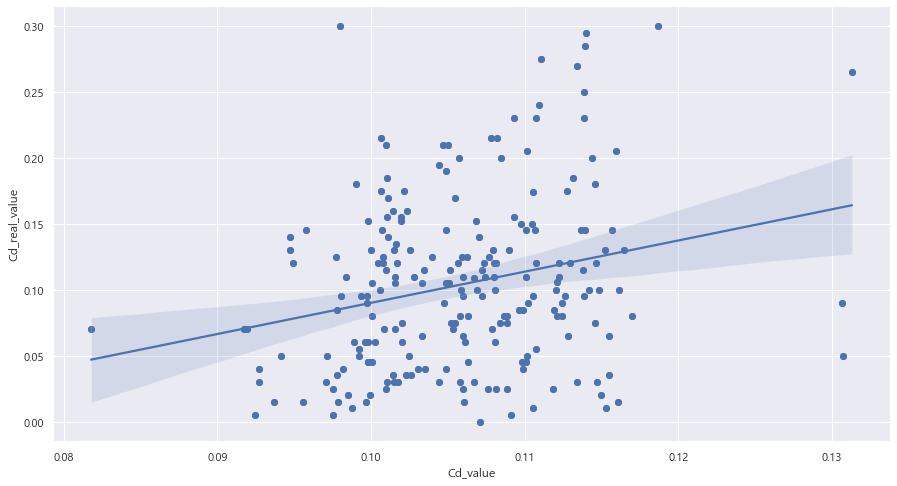

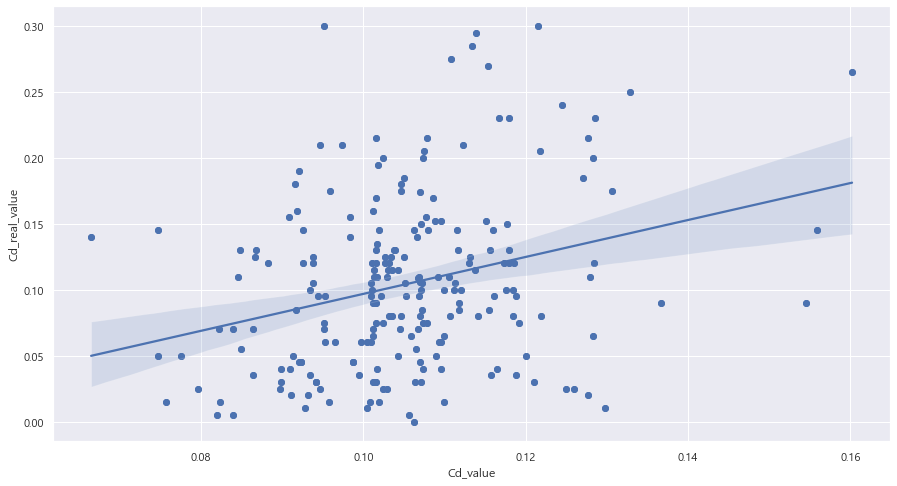

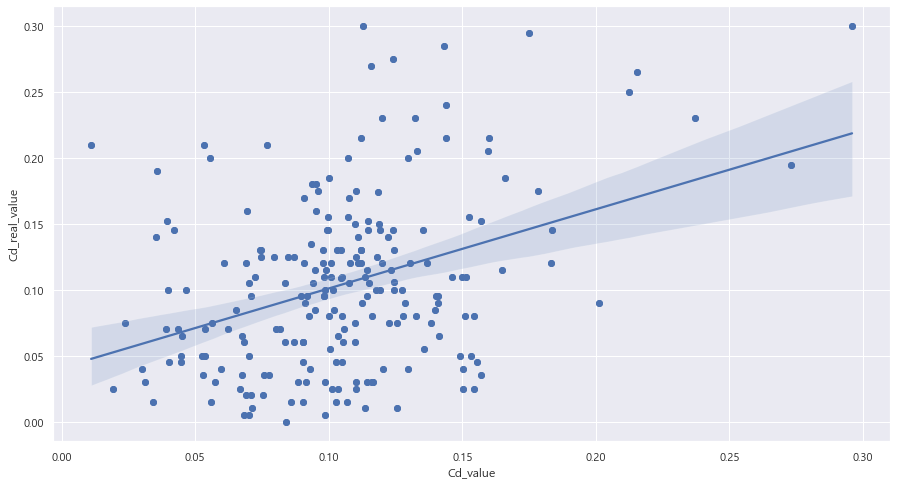

In [353]:
plt.scatter(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
sns.regplot(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
sns.regplot(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
sns.regplot(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
sns.regplot(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
sns.regplot(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
sns.regplot(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
sns.regplot(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
plt.show()

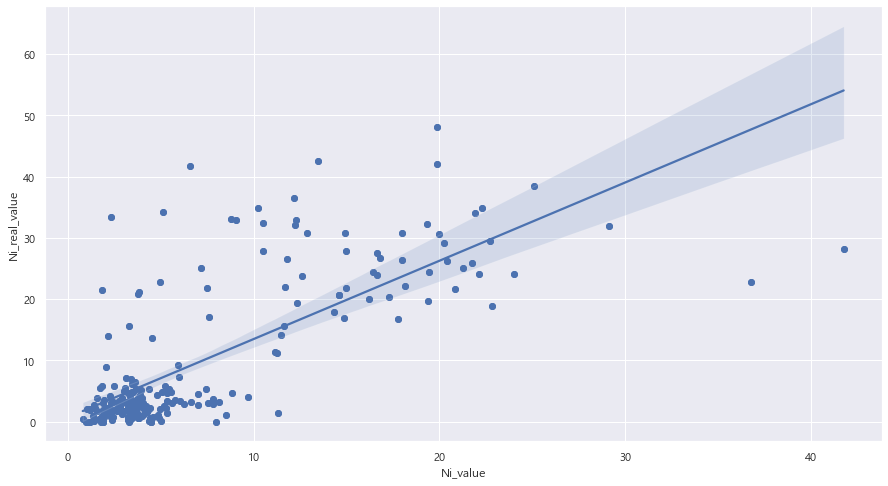

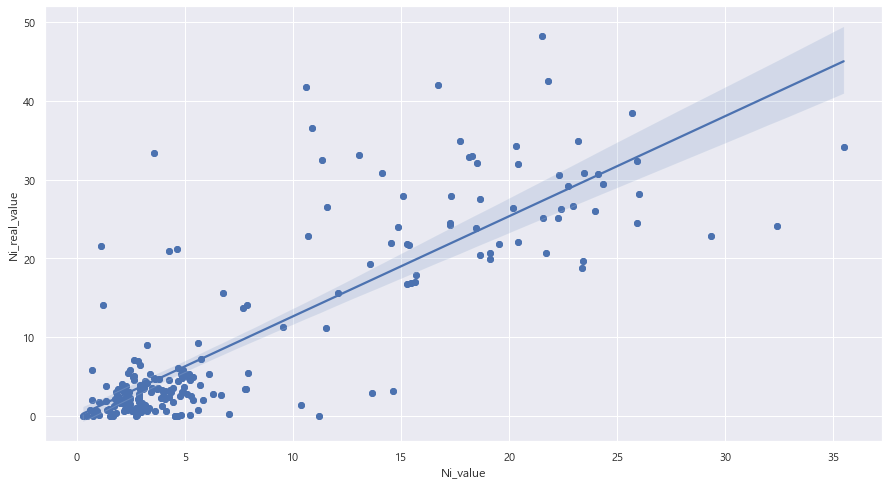

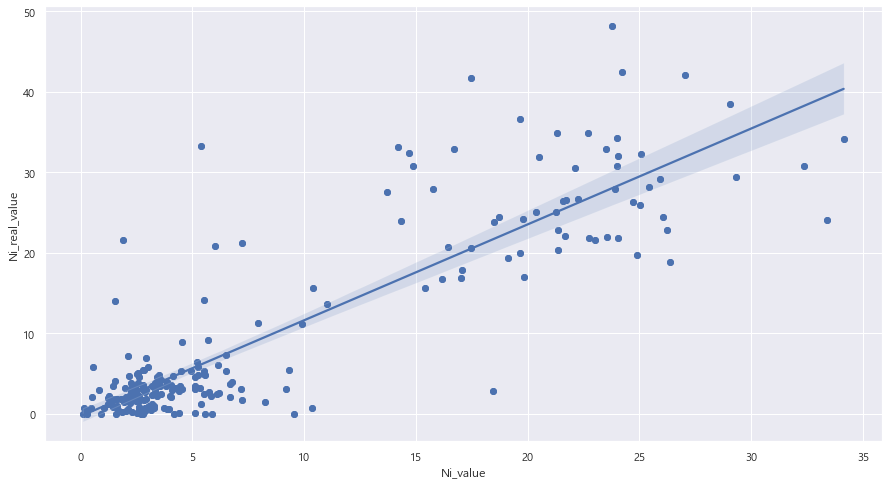

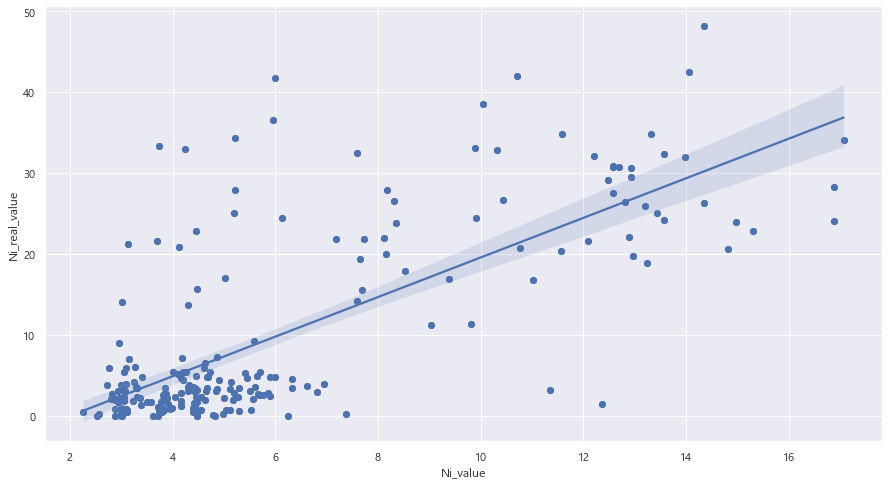

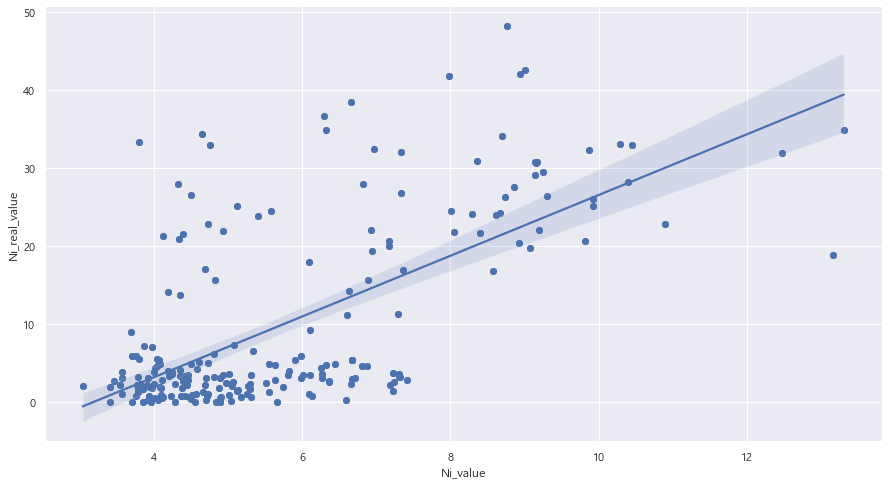

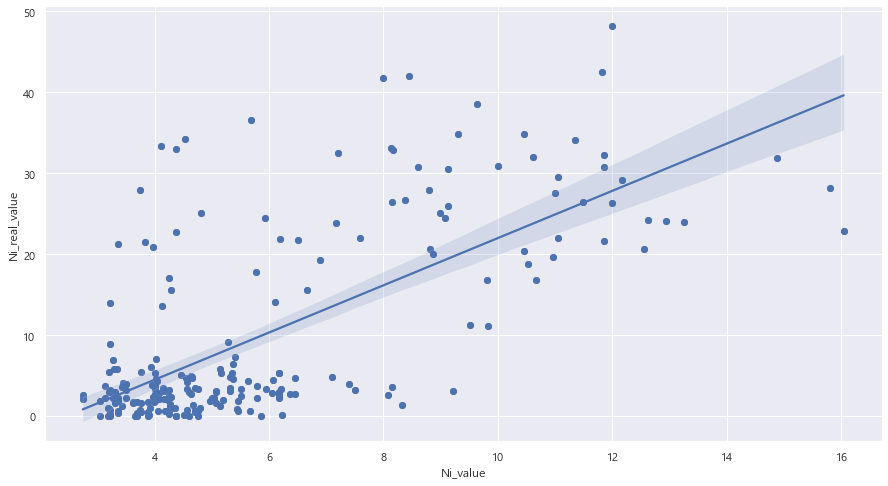

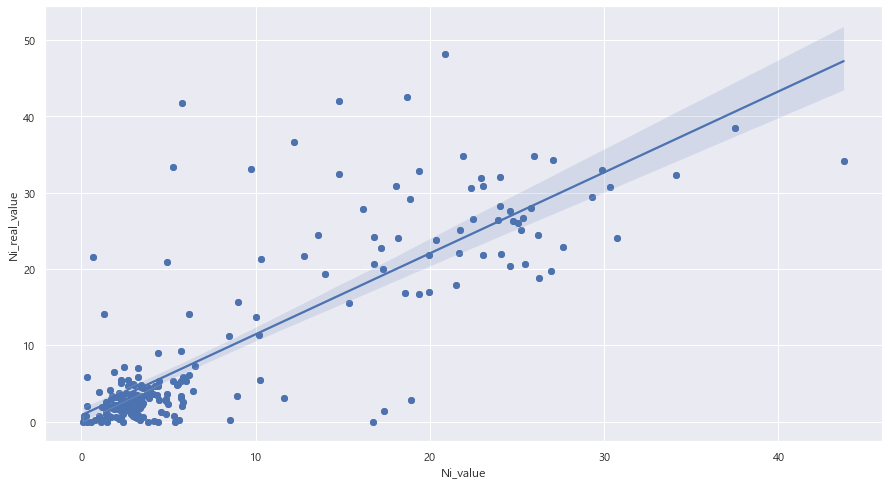

In [354]:
plt.scatter(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
sns.regplot(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
sns.regplot(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
sns.regplot(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
sns.regplot(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
sns.regplot(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
sns.regplot(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
sns.regplot(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
plt.show()